# 12. 오버피팅을 방지하는 방법
지금까지 실습은 학습만 있었지만 원래는 train, val, test data split을 수행하여야 한다.

## 실습12.4 데이터 나누기
### 1. 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [4]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [5]:
# train, val, test ratio
ratios = [.6, .2, .2]

In [6]:
train_cnt = int(data.size(0) * ratios[0])
val_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - val_cnt
cnts = [train_cnt, val_cnt, test_cnt]

print(f'Train {train_cnt}\tValid {val_cnt}\tTest {test_cnt}')

Train 12384	Valid 4128	Test 4128


In [7]:
# 랜덤샘플링
indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

In [8]:
# split
x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.shape, y_i.shape)

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


**학습데이터만 정규화하는것이 중요!**  
검증, 테스트데이터도 같이 fit을 하면 정답을 보고 transform을 하는 것과 같음

In [9]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float() # train
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float() # val
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float() # test

### 2. 학습코드 구현

In [10]:
# 학습에 필요한 값 설정
n_epochs = 4000
batch_size = 256
print_it = 200

# 학습률 필요 없음
# lr = 1e-2

In [11]:
# model
model = nn.Sequential(nn.Linear(x[0].size(-1), 6),
                      nn.LeakyReLU(),
                      nn.Linear(6, 5),
                      nn.LeakyReLU(),
                      nn.Linear(5, 4),
                      nn.LeakyReLU(),
                      nn.Linear(4, 3),
                      nn.LeakyReLU(),
                      nn.Linear(3, y[0].size(-1)),
                     )
model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [12]:
optimizer = optim.Adam(model.parameters())

In [13]:
# 학습 중 가장 좋은 모델 저장을 위한 파라미터 정의
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [14]:
train_history, val_history = [], []

for i in range(n_epochs):
    # 미니배치 나누기 전 shuffle
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss = 0
    y_hat = []
    
    # train data 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
    train_loss = train_loss / len(x_)
    
    # val data
    # 역전파 사용안함 = 그래디언트 계산할 필요 없음 = torch.no_grad
    with torch.no_grad():
        # 미니배치 나누기 전 shuffle 할 필요 없음
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        val_loss = 0
        
        # val data 학습
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            val_loss += float(loss)
            y_hat += [y_hat_i]
    
    val_loss = val_loss / len(x_)
        
    # history
    train_history += [train_loss]
    val_history += [val_loss]
    
    if (i+1)%print_it == 0:
        print(f'Epoch{i+1}\tTrainLoss {train_loss:.4e}\tValLoss {val_loss:.4e}\tlowest_loss {lowest_loss:.4e}')
        
    # lowest_loss & best_model
    if val_loss <= lowest_loss:
        lowest_loss = val_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1 :
            print(f'There is no improvment during last {early_stop} epochs.')
            break
            
print(f'The best validation loss from epoch {lowest_epoch+1}, lowest_loss {lowest_loss:.4e}')

Epoch200	Train Loss3.0130e-01	Val Loss3.4494e-01	lowest_loss0.34399240770760703
Epoch400	Train Loss2.9293e-01	Val Loss3.4404e-01	lowest_loss0.33750390831161947
Epoch600	Train Loss2.9119e-01	Val Loss3.3512e-01	lowest_loss0.3341900136540918
Epoch800	Train Loss2.8666e-01	Val Loss3.3352e-01	lowest_loss0.3324483448968214
Epoch1000	Train Loss2.8629e-01	Val Loss3.3454e-01	lowest_loss0.3315339754609501
Epoch1200	Train Loss2.8592e-01	Val Loss3.3171e-01	lowest_loss0.33037926169002757
There is no improvment during last 100 epochs.
The best validation loss from epoch 1287, lowest_loss 3.2960e-01


<All keys matched successfully>

### 3. 손실 곡선 확인

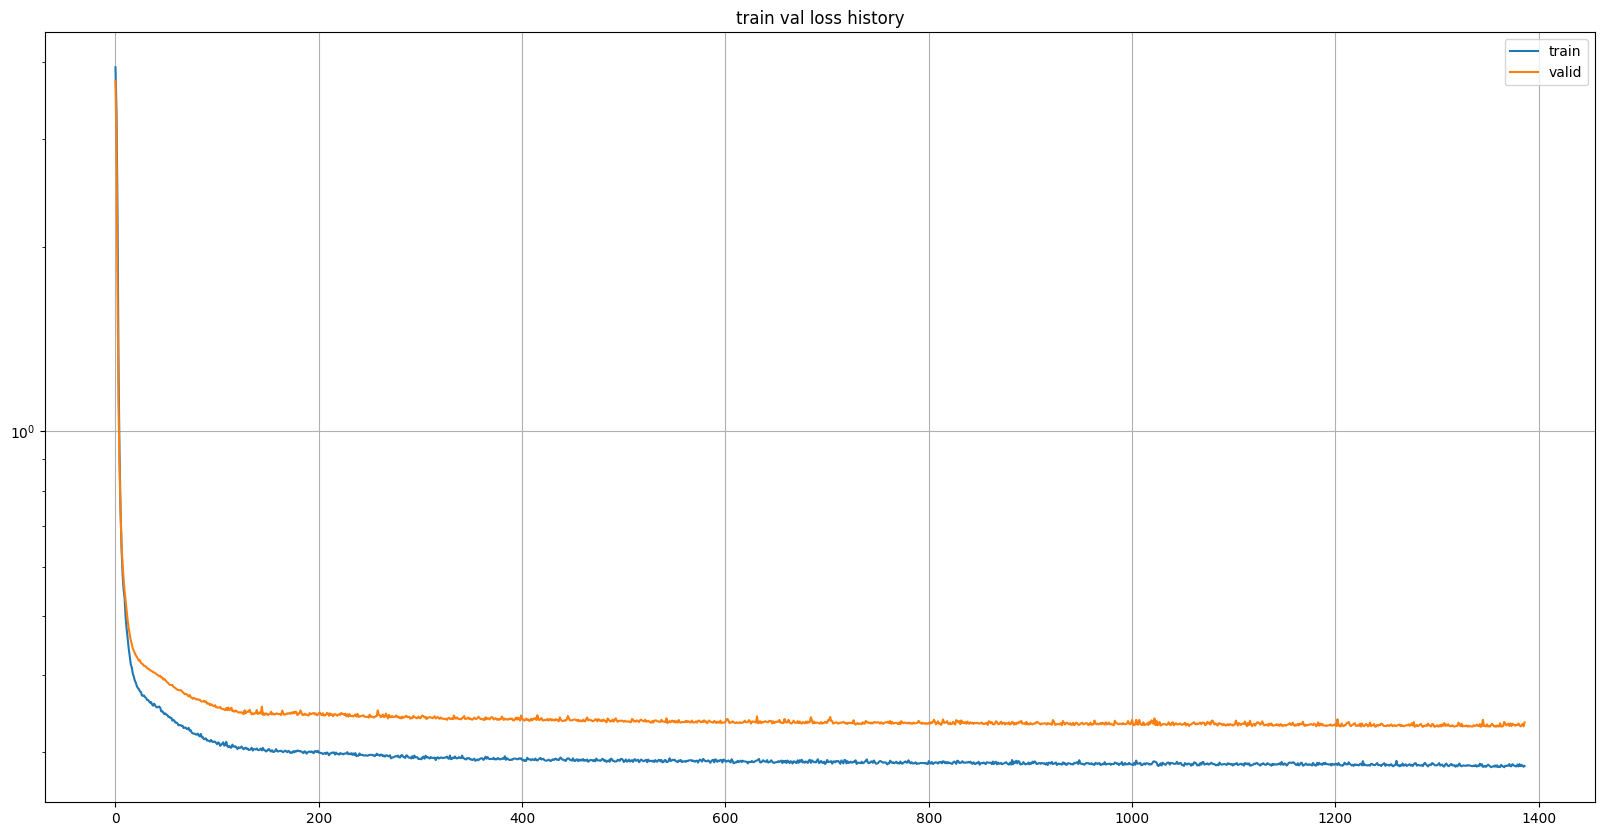

In [19]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('train val loss history')
plt.plot(train_history, label='train')
plt.plot(val_history, label='valid')
plt.yscale('log')
plt.legend()
plt.show()

### 4. 결과 확인 (test data 사용)

In [20]:
# load best model
model.load_state_dict(best_model)

<All keys matched successfully>

In [31]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ : x[2].split(batch_size, dim=0)
    y_ : y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        test_loss += float(loss)
        y_hat += [y_hat_i]
        
test_loss = test_loss/len(x_)
y_hat = torch.cat(y_hat, dim=0)

# 가장 낮은 검증 손실값(val)과 이에 대응하는 학습 손실값(train)을 값아서 테스트 손실값과 함께 출력하기 위함
sorted_history = sorted(zip(train_history, val_history), key=lambda x: x[1])

print(f'Train loss {sorted_history[0][0]:.4e}')
print(f'Val loss {sorted_history[0][1]:.4e}')
print(f'Test loss {test_loss:.4e}')

Train loss 2.8451e-01
Val loss 3.2960e-01
Test loss 3.2960e-01


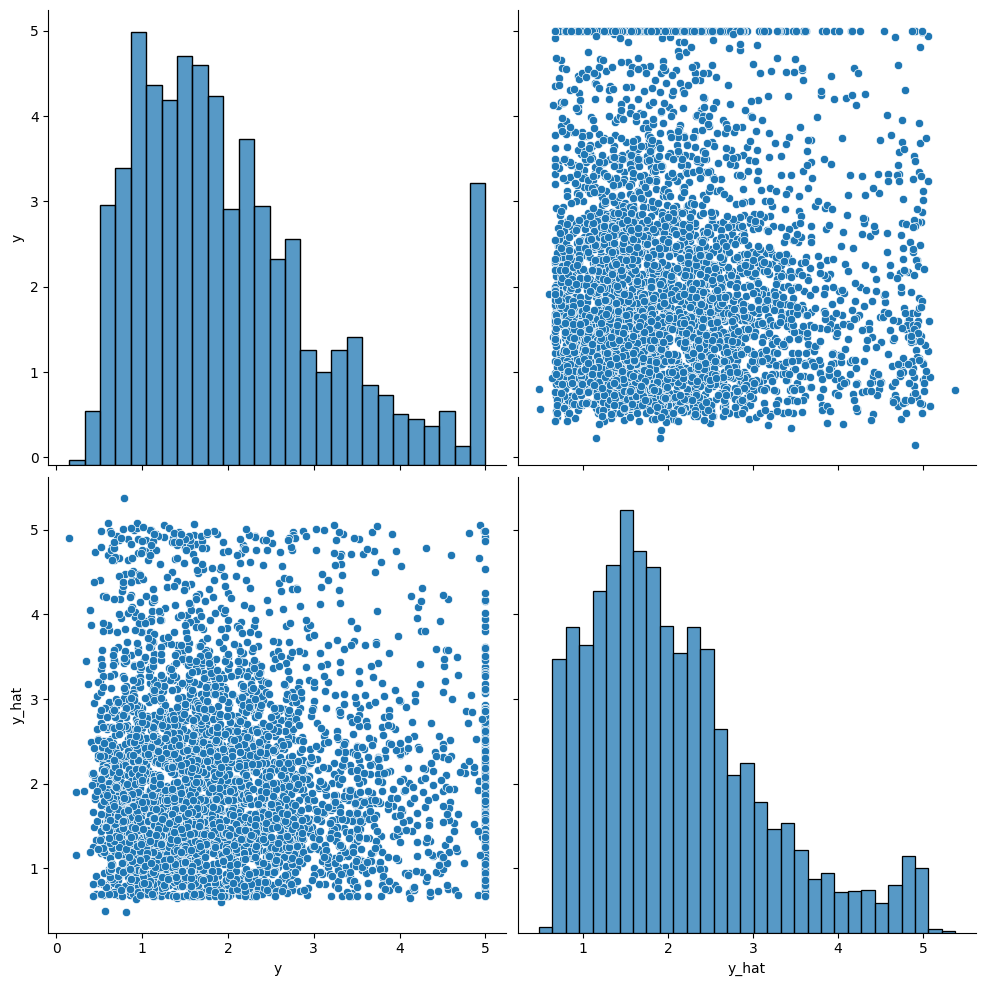

In [33]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat'])
sns.pairplot(df, height=5)